# 06. PyTorch Transfer Learning

## What is transfer learning?

**Transfer learning** allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as [ImageNet](https://www.image-net.org/) (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a [language model](https://developers.google.com/machine-learning/glossary#masked-language-model) (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

The premise remains: find a well-performing existing model and apply it to your own problem.

*Example of transfer learning being applied to computer vision and natural language processing (NLP). In the case of computer vision, a computer vision model might learn patterns on millions of images in ImageNet and then use those patterns to infer on another problem. And for NLP, a language model may learn the structure of language by reading all of Wikipedia (and perhaps more) and then apply that knowledge to a different problem.*

### More Models on

https://www.learnpytorch.io/06_pytorch_transfer_learning/

## Why use transfer learning?

There are two main benefits to using transfer learning:

1. Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
2. Can leverage a working model which has **already learned** patterns on similar data to our own. This often results in achieving **great results with less custom data**.

*We'll be putting these to the test for our FoodVision Mini problem, we'll take a computer vision model pretrained on ImageNet and try to leverage its underlying learned representations for classifying images of pizza, steak and sushi.*

Both research and practice support the use of transfer learning too.

A finding from a recent machine learning research paper recommended practitioners use transfer learning wherever possible.

*A study into the effects of whether training from scratch or using transfer learning was better from a practitioner's point of view, found transfer learning to be far more beneficial in terms of cost and time. **Source:** [How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers](https://arxiv.org/abs/2106.10270) paper section 6 (conclusion).*

And Jeremy Howard (founder of [fastai](https://www.fast.ai/)) is a big proponent of transfer learning.

> The things that really make a difference (transfer learning), if we can do better at transfer learning, it’s this world changing thing. Suddenly lots more people can do world-class work with less resources and less data. — [Jeremy Howard on the Lex Fridman Podcast](https://youtu.be/Bi7f1JSSlh8?t=72)




## What we're going to cover

We're going to take a pretrained model from `torchvision.models` and customise it to work on (and hopefully improve) our FoodVision Mini problem.

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Getting setup** | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again. |
| **1. Get data** | Let's get the pizza, steak and sushi image classification dataset we've been using to try and improve our model's results. |
| **2. Create Datasets and DataLoaders** | We'll use the `data_setup.py` script we wrote in chapter 05. PyTorch Going Modular to setup our DataLoaders. |
| **3. Get and customise a pretrained model** | Here we'll download a pretrained model from `torchvision.models` and customise it to our own problem. | 
| **4. Train model** | Let's see how the new pretrained model goes on our pizza, steak, sushi dataset. We'll use the training functions we created in the previous chapter. |
| **5. Evaluate the model by plotting loss curves** | How did our first transfer learning model go? Did it overfit or underfit?  |
| **6. Make predictions on images from the test set** | It's one thing to check out a model's evaluation metrics but it's another thing to view its predictions on test samples, let's *visualize, visualize, visualize*! |

## 0. Getting setup

Let's get started by importing/downloading the required modules for this section.

To save us writing extra code, we're going to be leveraging some of the Python scripts (such as `data_setup.py` and `engine.py`) we created in the previous section, 05. PyTorch Going Modular.

Specifically, we're going to download the [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

`torchinfo` will help later on to give us a visual representation of our model.

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
# try:
#     import torch
#     import torchvision
#     assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com, https://download.pytorch.org/whl/cu113
torch version: 2.7.1+cpu
torchvision version: 0.22.1+cpu


In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Before we can start to use **transfer learning**, we'll need a dataset.

To see how transfer learning compares to our previous attempts at model building, we'll download the same dataset we've been using for FoodVision Mini.

In [7]:
!python going_modular/get_data.py

data\pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi data...


In [8]:
# Set Dits
import os
import zipfile
from pathlib import Path

import requests

data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

Since we've downloaded the `going_modular` directory, we can use the [`data_setup.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/data_setup.py) script we created in section [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy) to prepare and setup our DataLoaders.

But since we'll be using a pretrained model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html), there's a specific transform we need to prepare our images first.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

> **Note:** As of `torchvision` v0.13+, there's an update to how data transforms can be created using `torchvision.models`. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in `torchvision.models`, the documentation stated:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

The good news is, we can achieve the above transformations with a combination of: 

| **Transform number** | **Transform required** | **Code to perform transform** | 
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]` and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  | 

> **Note:** some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of `torchvision.transforms` to perform the above steps.

In [9]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std = [0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

Now we've got a **manually created series of transforms** ready to prepare our images, let's create training and testing DataLoaders.

We can create these using the `create_dataloaders` function from the [`data_setup.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/data_setup.py) script we created in [05. PyTorch Going Modular Part 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy).

We'll set `batch_size=32` so our model sees mini-batches of 32 samples at a time.

And we can transform our images using the transform pipeline we created above by setting `transform=manual_transforms`.

> **Note:** I've included this manual creation of transforms in this notebook because you may come across resources that use this style. It's also important to note that because these transforms are manually created, they're also infinitely customizable. So if you wanted to include data augmentation techniques in your transforms pipeline, you could.

In [10]:
## Create training and testing DataLoaders as well as get a list of class names
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x17b72644d50>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As previously stated, when using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Above we saw how to manually create a transform for a pretrained model.

But as of `torchvision` v0.13+, an automatic transform creation feature has been added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:
    
```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

Where,
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many different model architecture options in `torchvision.models`).
* `DEFAULT` means the *best available* weights (the best performance in ImageNet).
    * **Note:** Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2` where generally the higher version number the better. Though if you want the best available, `DEFAULT` is the easiest option. See the [`torchvision.models` documentation](https://pytorch.org/vision/main/models.html) for more.
    

In [11]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

And now to access the transforms associated with our `weights`, we can use the `transforms()` method.

This is essentially saying "get the data transforms that were used to train the `EfficientNet_B0_Weights` on ImageNet".

In [12]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Notice how `auto_transforms` is very similar to `manual_transforms`, the only difference is that `auto_transforms` came with the model architecture we chose, where as we had to create `manual_transforms` by hand.

The benefit of automatically creating a transform through `weights.transforms()` is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

We can use `auto_transforms` to create DataLoaders with `create_dataloaders()` just as before.

In [13]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size = 32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x17b726452d0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customise it to your use case**.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... | 
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` | 
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... | 
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... | 
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` | 

### 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `efficientnet_b0()` -> `efficientnet_b1()` -> `efficientnet_b7()`) means *better performance* but a *larger* model.

You might think better performance is *always better*, right?

That's true but **some better performing models are too big for some devices**.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as [*The Bitter Lesson*](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) states, you'd likely take the biggest, most compute hungry model you can.

Understanding this **performance vs. speed vs. size** tradeoff will come with time and practice.

For me, I've found a nice balance in the `efficientnet_bX` models. 

As of May 2022, [Nutrify](https://nutrify.app) (the machine learning powered app I'm working on) is powered by an `efficientnet_b0`.

[Comma.ai](https://comma.ai/) (a company that makes open source self-driving car software) [uses an `efficientnet_b2`](https://geohot.github.io/blog/jekyll/update/2021/10/29/an-architecture-for-life.html) to learn a representation of the road.

> **Note:** Even though we're using `efficientnet_bX`, it's important not to get too attached to any one architecture, as they are always changing as new research gets released. Best to experiment and see what works for your problem. 

### 3.2 Setting up a pretrained model

The pretrained model we're going to be using is [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html).

The architecture is from the paper *[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)*.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png" alt="efficienet_b0 from PyTorch torchvision feature extraction model" width=900/>

*Example of what we're going to create, a pretrained [`EfficientNet_B0` model](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html) from `torchvision.models` with the output layer adjusted for our use case of classifying pizza, steak and sushi images.*

We can setup the `EfficientNet_B0` pretrained ImageNet weights using the same code as we used to create the transforms.


```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights for ImageNet
```

This means the model has already been trained on millions of images and has a good base representation of image data.

The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.

We'll also send it to the target device.

In [14]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
# Notice: Capital and small letter for building model and getting weights
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Our `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default). 

In [15]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model = model,
        input_size = (32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names = ['input_size'], # uncomment for smaller output
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-unfrozen-layers.png" alt="output of torchinfo.summary() when passed our model with all layers as trainable" width=900/>

Now that's a big model!

From the output of the summary, we can see all of the various input and output shape changes as our image data goes through the model.

And there are a whole bunch more total parameters (pretrained weights) to recognize different patterns in our data.

For reference, our model from previous sections, **TinyVGG had 8,083 parameters vs. 5,288,548 parameters for `efficientnet_b0`, an increase of ~654x**!

What do you think, will this mean better performance?

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnet-changing-the-classifier-head.png" alt="changing the efficientnet classifier head to a custom number of outputs" width=900/>

*You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original `torchvision.models.efficientnet_b0()` comes with `out_features=1000` because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need `out_features=3`.*

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0` model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [16]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

Feature extractor layers frozen!

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

We can change the `classifier` portion of our model by creating a new series of layers.

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

> **Note:** [Dropout layers](https://developers.google.com/machine-learning/glossary#dropout_regularization) randomly remove connections between two neural network layers with a probability of `p`. For example, if `p=0.2`, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are *more general*). 

And we'll keep `in_features=1280` for our `Linear` output layer but we'll change the `out_features` value to the length of our `class_names` (`len(['pizza', 'steak', 'sushi']) = 3`).

Our new `classifier` layer should be on the same device as our `model`. 

In [18]:
from torch import nn
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = output_shape, bias = True)
).to(device) # remember to m=out submodule into 'device'

In [19]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size = (32, 3, 224, 224),
        verbose = 0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-frozen-layers.png" alt="output of torchinfo.summary() after freezing multiple layers in our model and changing the classifier head" width=900/>

Ho, ho! There's a fair few changes here!

Let's go through them:
* **Trainable column** - You'll see that many of the base layers (the ones in the `features` portion) have their Trainable value as `False`. This is because we set their attribute `requires_grad=False`. Unless we change this, these layers won't be updated during future training.
* **Output shape of `classifier`** - The `classifier` portion of the model now has an Output Shape value of `[32, 3]` instead of `[32, 1000]`. It's Trainable value is also `True`. This means its parameters will be updated during training. In essence, we're using the `features` portion to feed our `classifier` portion a base representation of an image and then our `classifier` layer is going to learn how to base representation aligns with our problem.
* **Less trainable parameters** - Previously there were 5,288,548 trainable parameters. But since we froze many of the layers of the model and only left the `classifier` as trainable, there's now only 3,843 trainable parameters (even less than our TinyVGG model). Though there's also 4,007,548 non-trainable parameters, these will create a base representation of our input images to feed into our `classifier` layer.

> **Note:** The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quite quickly. This is one huge benefit of transfer learning, taking the already learned parameters of a model trained on a problem similar to yours and only tweaking the outputs slightly to suit your problem.

## 4. Train model

Now we've got a pretrained model that's semi-frozen and has a customised `classifier`, we can leverage transfer learning.

To begin training, let's create a loss function and an optimizer.

Because we're still working with multi-class classification, we'll use `nn.CrossEntropyLoss()` for the loss function.

And we'll stick with `torch.optim.Adam()` as our optimizer with `lr=0.001`.


In [20]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

To train our model, we can use `train()` function we defined in the [05. PyTorch Going Modular section 04](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them).

The `train()` function is in the [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py) script inside the [`going_modular` directory](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular). 

Let's see how long it takes to train our model for 5 epochs.

> **Note:** We're only going to be training the parameters `classifier` here as all of the other parameters in our model have been frozen.

In [21]:
from going_modular import engine
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\Jorden\anaconda3\envs\torch\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 20%|██        | 1/5 [00:43<02:52, 43.12s/it]

Epoch: 1 | train_loss: 1.0883 | train_acc: 0.4180 | test_loss: 0.8914 | test_acc: 0.6818


 40%|████      | 2/5 [01:19<01:57, 39.10s/it]

Epoch: 2 | train_loss: 0.9162 | train_acc: 0.6289 | test_loss: 0.8027 | test_acc: 0.7443


 60%|██████    | 3/5 [01:57<01:16, 38.48s/it]

Epoch: 3 | train_loss: 0.8162 | train_acc: 0.7031 | test_loss: 0.6787 | test_acc: 0.9072


 80%|████████  | 4/5 [02:36<00:38, 38.66s/it]

Epoch: 4 | train_loss: 0.7460 | train_acc: 0.7305 | test_loss: 0.6744 | test_acc: 0.8040


100%|██████████| 5/5 [03:12<00:00, 38.59s/it]

Epoch: 5 | train_loss: 0.6209 | train_acc: 0.7695 | test_loss: 0.6263 | test_acc: 0.8561
[INFO] Total training time: 192.952 seconds


## 5. Evaluate model by plotting loss curves

Our model looks like it's performing pretty well.

Let's plot it's loss curves to see what the training looks like over time. 

We can plot the loss curves using the function `plot_loss_curves()` we created in [04. PyTorch Custom Datasets section 7.8](https://www.learnpytorch.io/04_pytorch_custom_datasets/#78-plot-the-loss-curves-of-model-0).

The function is stored in the [`helper_functions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) script so we'll try to import it and download the script if we don't have it.

[INFO] Couldn't find helper_functions.py, downloading...


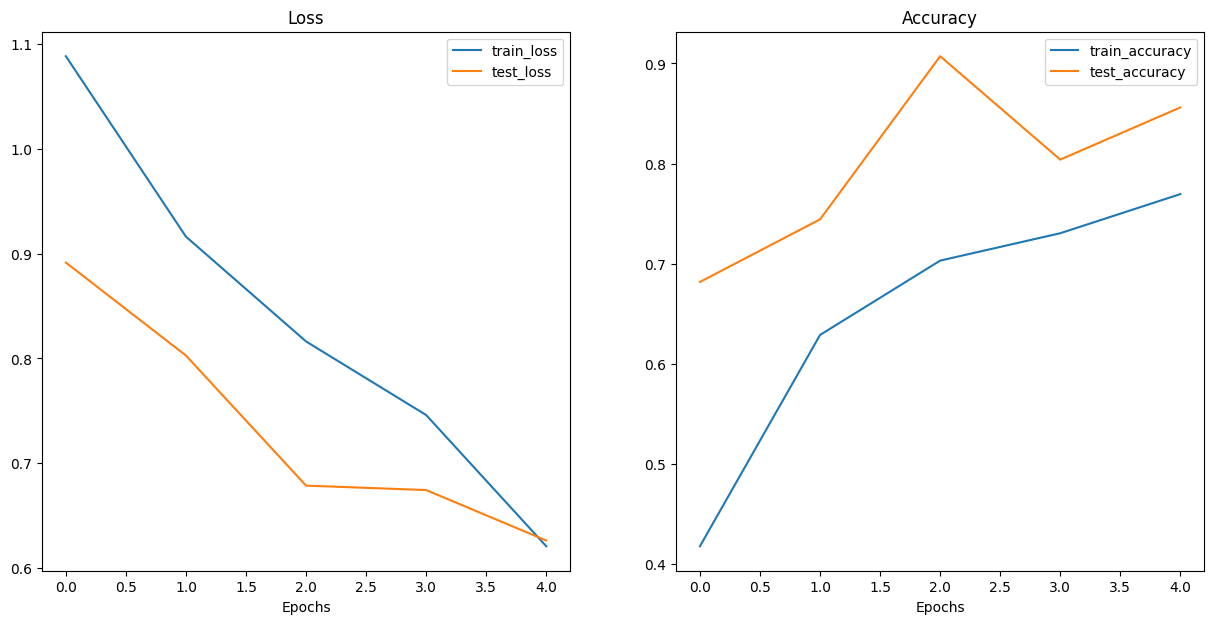

In [22]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open('helper_functions.py', 'wb') as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)


## 6. Make predictions on images from the test set

Let's find out by making some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make predictions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

In [23]:
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model,
                        image_path, 
                        class_names,
                        image_size = (224, 224),
                        transform = None,
                        device = device):
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
        ])
    
    ### Predict on image ###

    # 4. pred the image
    model.eval()
    with torch.inference_mode():
        # 5. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transform_image = image_transform(img).unsqueeze(dim = 0)

        # 6. Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transform_image.to(device))

        # 7. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
        target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

        # 8. Convert prediction probabilities -> prediction labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

        # 10. Plot image with predicted label and probability 
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
        plt.axis(False);

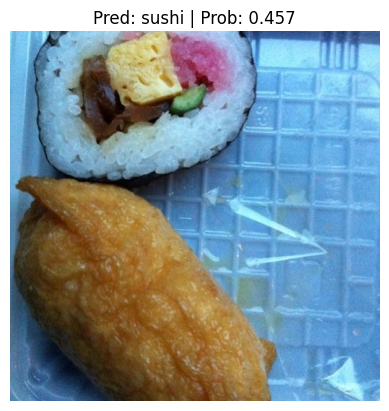

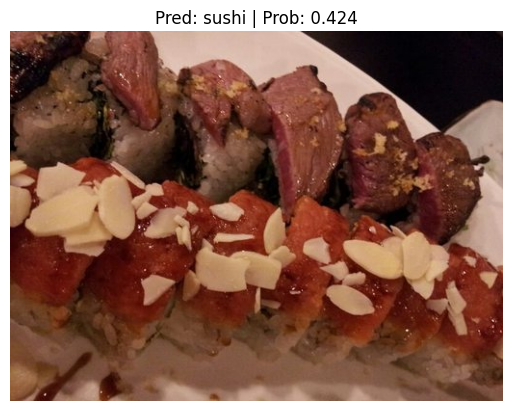

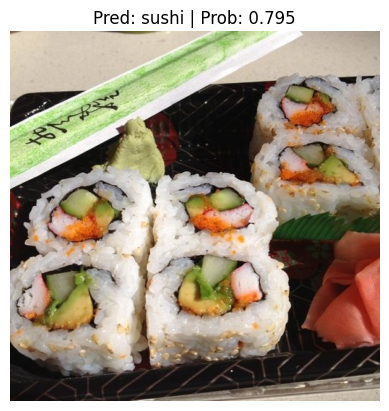

In [24]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(test_image_path_list, k = num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image

It looks like our model does well qualitatively on data from the test set.

But how about on our own custom image?

That's where the real fun of machine learning is!

Predicting on your own custom data, outside of any training or test set.

To test our model on a custom image, let's import the old faithful `pizza-dad.jpeg` image (an image of my dad eating pizza).

We'll then pass it to the `pred_and_plot_image()` function we created above and see what happens.

data\04-pizza-dad.jpeg already exists, skipping download.


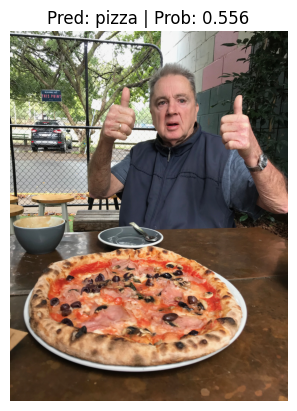

In [26]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model, custom_image_path, class_names)

# END!

## Exercise 1

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

from torchinfo import summary
from going_modular import data_setup, engine

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


c:\Users\Jorden\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
# Set Dits
import os
import zipfile
from pathlib import Path

import requests

data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

### Get the data with transforms

In [50]:
# Get the transforms used to create our pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [51]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size = 32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x289c7c17ad0>,
 ['pizza', 'steak', 'sushi'])

### Get and Pretrain a model

In [52]:
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
# Freeze all base layers in the "features" section of the model
for param in model.features.parameters():
    param.required_grad = False
summary(model, (32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

In [53]:
# Set the final layer to be our target classification classes
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280,
              out_features = output_shape,
              bias = True)).to(device)


### Fine-tune the model

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [55]:
from going_modular import engine
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:44<02:57, 44.34s/it]

Epoch: 1 | train_loss: 0.7852 | train_acc: 0.6523 | test_loss: 0.2942 | test_acc: 0.8873


 40%|████      | 2/5 [01:18<01:55, 38.42s/it]

Epoch: 2 | train_loss: 0.1726 | train_acc: 0.9766 | test_loss: 0.2044 | test_acc: 0.9280


 40%|████      | 2/5 [01:35<02:23, 47.68s/it]


KeyboardInterrupt: 

In [9]:
from tqdm.auto import tqdm
test_preds = []
model.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        # Pass the data through the model
        test_logits = model(X)

        # Convert the pred logits to pred probs
        test_prob = torch.softmax(test_logits, dim = 1)

        # Covert the probs into pred labels
        pred_labels = torch.argmax(test_prob, dim = 1)

        # Add the pred labels to test preds list
        test_preds.append(pred_labels)

test_preds = torch.cat(test_preds)
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:33<00:00, 11.28s/it]


tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2], device='cuda:0')

### Make a confusion matrix


In [10]:
test_truth = [y for X, y in test_dataloader]
test_truth = torch.cat(test_truth)
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes = len(class_names))
confmat_tensor = confmat(pred = test_preds,
                         target = test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), # matplotlib likes working with numpy
    figsize = (10, 7)
)

ModuleNotFoundError: No module named 'mlxtend'

#### 2. Get the "most wrong" of the predictions

In [24]:
# Create a DataFrame


# Get all test data data path
from pathlib import Path
test_data_paths = list(test_dir.glob("*/*.jpg"))
test_labels = [path.parent.name for path in test_data_paths]

# Create a function to return a list of dictionaries with sample. label, prediction. pred prob
def pred_and_store(model, data_paths, transform):
    test_pred_list = []
    model.eval()
    
    with torch.inference_mode():
        for path in data_paths:
            pred_dict = {}

            class_name = path.parent.name

            # Get sample path
            pred_dict['image_path'] = path

            # Get class name
            pred_dict['image_true_label'] = class_name

            # Get prediction
            from PIL import Image
            img = Image.open(path)

            transformed_img = transform(img).unsqueeze(0) # transfroms image and add batch dimension
            pred_logit = model(transformed_img.to(device))
            pred_prob = torch.softmax(pred_logit, dim = 1).max().item()
            pred_label = torch.argmax(torch.softmax(pred_logit, dim = 1), dim = 1)

            pred_dict['pred_prob'] = pred_prob
            pred_dict['pred_label'] = class_names[pred_label]

            # Does the pred match the true label?
            pred_dict['correct'] = class_name == class_names[pred_label]

            # Add the dictionary to the list of preds
            test_pred_list.append(pred_dict)

    return test_pred_list

result = pred_and_store(model, test_data_paths, auto_transforms)
result

[{'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
  'image_true_label': 'pizza',
  'pred_prob': 0.5714417099952698,
  'pred_label': 'steak',
  'correct': False},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
  'image_true_label': 'pizza',
  'pred_prob': 0.9986109733581543,
  'pred_label': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
  'image_true_label': 'pizza',
  'pred_prob': 0.9562437534332275,
  'pred_label': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
  'image_true_label': 'pizza',
  'pred_prob': 0.9919812679290771,
  'pred_label': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
  'image_true_label': 'pizza',
  'pred_prob': 0.9381021857261658,
  'pred_label': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/tes

In [34]:
import pandas as pd
test_pred_df = pd.DataFrame(result)
top_5_most_wrong = test_pred_df.sort_values(by = ['correct', 'pred_prob'], ascending = [True, False]).head()

C:\Users\Jorden\AppData\Local\Temp\ipykernel_37600\2887112675.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
C:\Users\Jorden\AppData\Local\Temp\ipykernel_37600\2887112675.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
C:\Users\Jorden\AppData\Local\Temp\ipykernel_37600\2887112675.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
C:\Users\Jorden\AppData\Local\Temp\

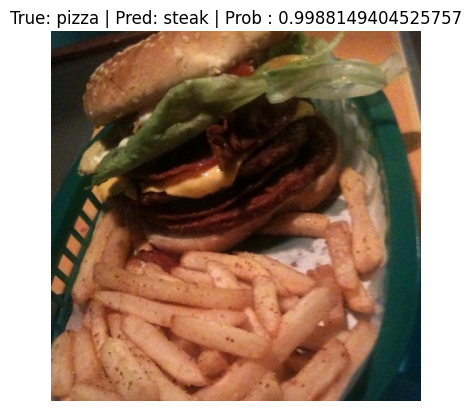

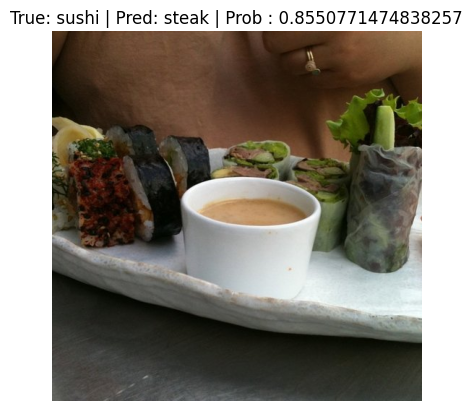

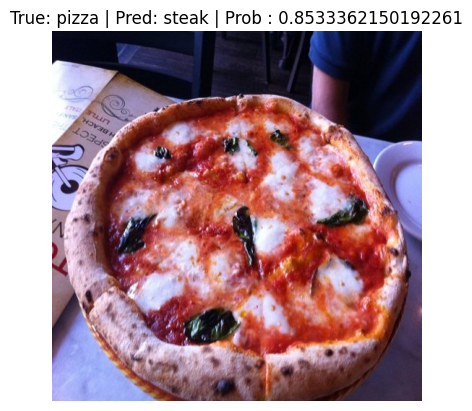

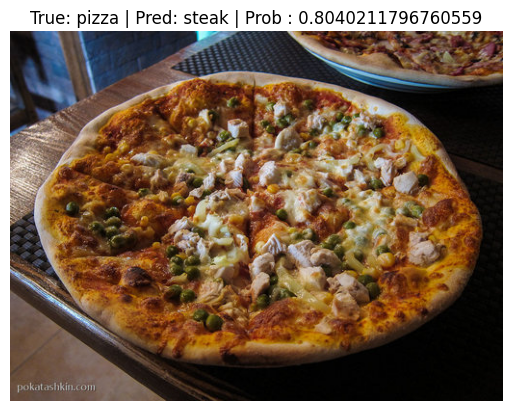

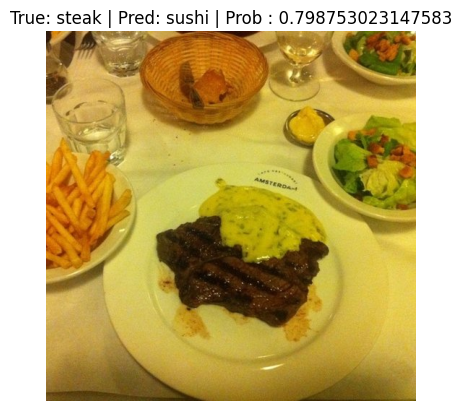

In [40]:
import matplotlib.pyplot as plt
most_wrong_image_paths = top_5_most_wrong['image_path'].to_list()
for row in top_5_most_wrong.iterrows():
    row = row[1]
    image_path = row[0]
    true_label = row[1]
    pred_prob = row[2]
    pred_class = row[3]
    # Plot the most wrong image
    img = torchvision.io.read_image(str(image_path))
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob : {pred_prob}")
    plt.axis(False)

## 4. Retrain our model with longer epochs

In [65]:
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

model_1 = torchvision.models.efficientnet_b0(weights = weights).to(device)
for param in model_1.features.parameters():
    param.requires_grad = False

In [66]:
model_1.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(1280, len(class_names), bias = True)
).to(device)

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = 0.001)


In [68]:
from going_modular import engine
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup training and save the results
results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs= 10,
                       device=device)

 10%|█         | 1/10 [00:37<05:35, 37.25s/it]

Epoch: 1 | train_loss: 1.0671 | train_acc: 0.4531 | test_loss: 0.8281 | test_acc: 0.7945


 20%|██        | 2/10 [01:08<04:31, 33.95s/it]

Epoch: 2 | train_loss: 0.8394 | train_acc: 0.7891 | test_loss: 0.7459 | test_acc: 0.7339


 30%|███       | 3/10 [01:41<03:53, 33.38s/it]

Epoch: 3 | train_loss: 0.7363 | train_acc: 0.8398 | test_loss: 0.7127 | test_acc: 0.7841


 40%|████      | 4/10 [02:12<03:14, 32.39s/it]

Epoch: 4 | train_loss: 0.6896 | train_acc: 0.7734 | test_loss: 0.6210 | test_acc: 0.8456


 50%|█████     | 5/10 [02:44<02:40, 32.20s/it]

Epoch: 5 | train_loss: 0.6063 | train_acc: 0.8125 | test_loss: 0.6120 | test_acc: 0.8759


 60%|██████    | 6/10 [03:17<02:09, 32.36s/it]

Epoch: 6 | train_loss: 0.5417 | train_acc: 0.9180 | test_loss: 0.5600 | test_acc: 0.8352


 70%|███████   | 7/10 [03:47<01:35, 31.88s/it]

Epoch: 7 | train_loss: 0.5009 | train_acc: 0.9453 | test_loss: 0.5279 | test_acc: 0.8153


 80%|████████  | 8/10 [04:19<01:03, 31.82s/it]

Epoch: 8 | train_loss: 0.4888 | train_acc: 0.8242 | test_loss: 0.5189 | test_acc: 0.8769


 90%|█████████ | 9/10 [04:52<00:32, 32.03s/it]

Epoch: 9 | train_loss: 0.5421 | train_acc: 0.8242 | test_loss: 0.4946 | test_acc: 0.8551


100%|██████████| 10/10 [05:28<00:00, 32.83s/it]

Epoch: 10 | train_loss: 0.4624 | train_acc: 0.8125 | test_loss: 0.4376 | test_acc: 0.8759


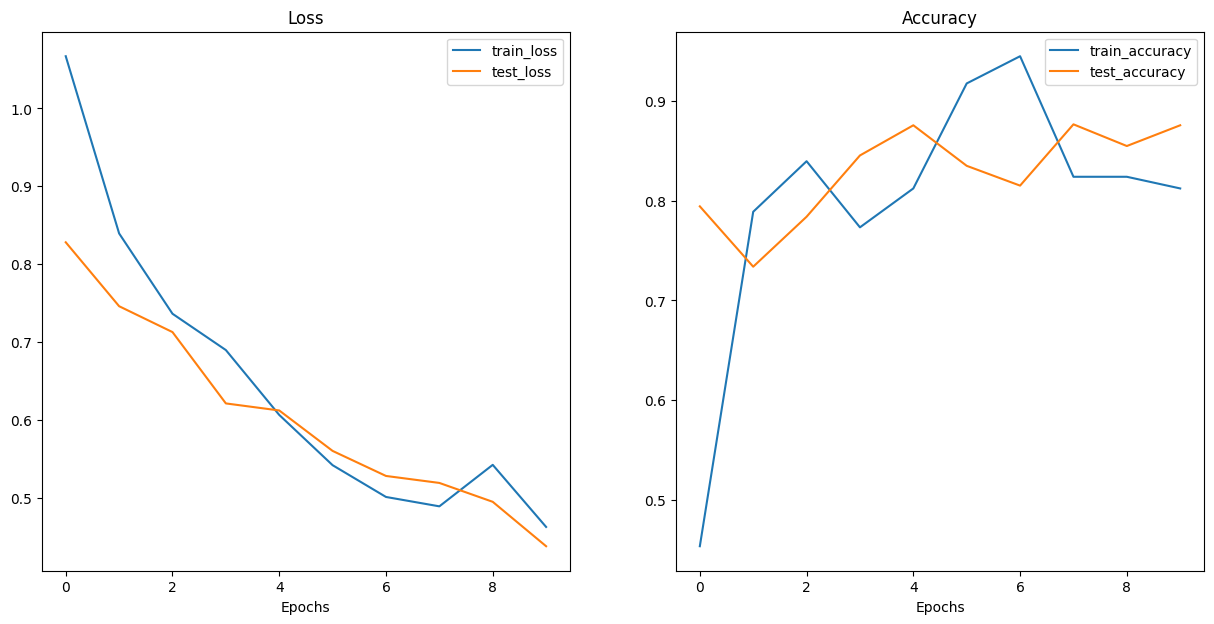

In [69]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open('helper_functions.py', 'wb') as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

#### 5. Train the model with more data, 20% of food 101

In [74]:
# Set Dits
import os
import zipfile
from pathlib import Path

import requests

data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi_20"

train_dir = image_path / "train"
test_dir = image_path / "test"

In [75]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

In [76]:
## Create training and testing DataLoaders as well as get a list of class names
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x289cb8d3590>,
 ['pizza', 'steak', 'sushi'])

In [79]:
model_2 = torchvision.models.efficientnet_b0(weights = weights).to(device)
for param in model_2.features.parameters():
    param.requires_grad = False

model_2.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(1280, len(class_names), bias = True)
).to(device)

In [80]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = 0.001)

In [81]:
from going_modular import engine
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup training and save the results
results = engine.train(model=model_2,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs= 5,
                       device=device)

 20%|██        | 1/5 [00:43<02:55, 43.85s/it]

Epoch: 1 | train_loss: 0.9987 | train_acc: 0.5333 | test_loss: 0.6902 | test_acc: 0.9017


 40%|████      | 2/5 [01:24<02:06, 42.15s/it]

Epoch: 2 | train_loss: 0.7008 | train_acc: 0.8500 | test_loss: 0.5580 | test_acc: 0.9040


 60%|██████    | 3/5 [02:00<01:18, 39.36s/it]

Epoch: 3 | train_loss: 0.6041 | train_acc: 0.8000 | test_loss: 0.4755 | test_acc: 0.9006


 80%|████████  | 4/5 [02:33<00:36, 36.86s/it]

Epoch: 4 | train_loss: 0.4508 | train_acc: 0.9000 | test_loss: 0.4278 | test_acc: 0.8909


100%|██████████| 5/5 [03:08<00:00, 37.75s/it]

Epoch: 5 | train_loss: 0.4405 | train_acc: 0.8896 | test_loss: 0.4029 | test_acc: 0.9227


#### 6. Try `EfficientNet_B2`

In [82]:
from torchvision import transforms, models

transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

In [84]:
data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

In [85]:
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir,
                                                                                                   test_dir,
                                                                                                   transform = transform,
                                                                                                   batch_size = 32)

In [87]:
weights = models.EfficientNet_B2_Weights.DEFAULT
model_3 = models.efficientnet_b2(weights = weights).to(device)
model_3

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [88]:
for param in model_3.features.parameters():
    param.requires_grad = False

torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True),
    nn.Linear(1408, out_features = len(class_names), bias = True)
).to(device)

In [90]:
summary(model_3,
        input_size = [32, 3, 288, 288],
        col_names = ['input_size', 'output_size', 'trainable'])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 288, 288]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 288, 288]         [32, 1408, 9, 9]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]         [32, 32, 144, 144]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]         [32, 32, 144, 144]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144]        [32, 32, 144, 144]        False
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144]        [32, 32, 144, 144]        --
│    └─Sequential: 2-2                                  [32, 32, 144, 144]        [32, 16, 144, 144]        False
│    │    └─MBConv: 3-4                                 [32, 32, 144, 144]        [32

In [91]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr = 0.001)

In [92]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# Setup training and save the results
results = engine.train(model = model_3,
                       train_dataloader= train_dataloader_effnet_b2,
                       test_dataloader=test_dataloader_effnet_b2,
                       optimizer= optimizer,
                       loss_fn= loss_fn,
                       epochs= 5,
                       device= device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:39<02:39, 39.83s/it]

Epoch: 1 | train_loss: 1.1048 | train_acc: 0.3398 | test_loss: 0.9105 | test_acc: 0.6723


 40%|████      | 2/5 [01:12<01:46, 35.52s/it]

Epoch: 2 | train_loss: 0.8944 | train_acc: 0.6680 | test_loss: 0.8659 | test_acc: 0.8352


 60%|██████    | 3/5 [01:44<01:07, 33.81s/it]

Epoch: 3 | train_loss: 0.8057 | train_acc: 0.7852 | test_loss: 0.7902 | test_acc: 0.8049


 80%|████████  | 4/5 [02:16<00:33, 33.35s/it]

Epoch: 4 | train_loss: 0.7358 | train_acc: 0.7617 | test_loss: 0.6720 | test_acc: 0.9280


100%|██████████| 5/5 [02:48<00:00, 33.69s/it]

Epoch: 5 | train_loss: 0.6495 | train_acc: 0.8086 | test_loss: 0.6585 | test_acc: 0.8466
[INFO] Total training time: 168.444 seconds
